**Author:** Anowar J. Shajib

This notebook introduces various softwares to apply Bayesian inference on data. The purpose is to only introduce them while keeping in touch with the basic concepts behind the Bayesian inference. For more details on how to use these softwares (`emcee`, `dynesty`, etc.), check their respective documentations. They have a useful number of illulstrative examples.

## Imports

The following `python` packages are used in this notebook, in addition to those that come with a standard anaconda installation.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

sns.set_context(context='talk',font_scale=0.7)

## Generate data

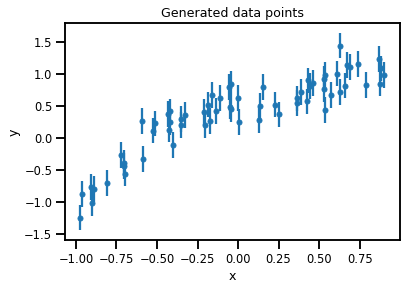

In [2]:
N = 64
x = np.random.uniform(low=-1, high=1, size=N)

y_true = 0.5 + 0.4*x - 0.5*x**2 + x**3
y_uncertainty = 0.2

y = np.random.normal(loc=y_true, scale=y_uncertainty)

plt.errorbar(x, y, yerr=y_uncertainty, ls='none', marker='o', markersize=5)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Generated data points');

# Maximum Likelihood Estimate (MLE): the Frequentist way of life

This notebook uses $x$ (or, $\mathbf{x}$) and $y$ (or, $\mathbf{y}$) to denote data points (or, vector), $\hat{x}$ for a given arbitrary value, and $\hat{y}$ for the predicted value for given $\hat{x}$. The model to fit a line is: $\hat{y} = m\hat{x} +b$. The likelihood function for Gaussian noise is

$$p(\hat{y} \mid m, b) = \prod_i \frac{1}{\sqrt{2 \pi} \sigma_i}\exp(-\chi_i^2/2),$$

with 

$$\chi_i^2 = \frac{(y_i - mx_i - b)^2}{\sigma_i^2}.$$

Maximizing the likelihood is thus equivalent to minimizing the $\chi^2 = \sum_i \chi_i^2$. Then, $\mathbf{b}$ = $[m, b]$ can be expressed using the matrix $\textbf{X} = [\mathbf{x}, \mathbf{1}]$ and the covariance matrix $\textbf{C}$ as 

$$ \mathbf{b} = (\textbf{X}^\top \textbf{C}^{-1} \textbf{X})^{-1} \textbf{X}^\top \textbf{C}^{-1} \mathbf{y} .$$

m: 0.94, b: 0.39


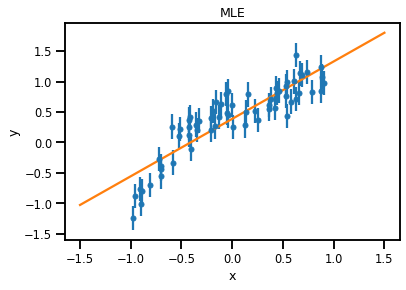

In [3]:
X = np.array([[a, 1] for a in x])

C_inv = np.zeros((len(y), len(y)))
np.fill_diagonal(C_inv, 1/y_uncertainty**2)

M1 = np.matmul(np.matmul(X.transpose(), C_inv), X)
M2 = np.matmul(np.matmul(X.transpose(), C_inv), y)

[m, b] = np.matmul(np.linalg.inv(M1), M2)

print('m: {:.2f}, b: {:.2f}'.format(m, b))

x_test = np.linspace(-1.5, 1.5, 100)

plt.errorbar(x, y, yerr=y_uncertainty, ls='none', marker='o', markersize=5)
plt.plot(x_test, m*x_test+b)
plt.xlabel('x')
plt.ylabel('y')
plt.title('MLE');

# Bayesian inference

In the Bayesian framework, we want to infer 

$$p(m, b \mid M, D) = \frac{p(D \mid m, b, M) p(m, b \mid M)}{p(D \mid M)}$$ 

where $M$ is the model, $D = \{\mathbf{x}, \mathbf{y}\}$ is the data. $p(m, b \mid M, D)$ is called the *posterior* of $m$ and $b$, $p(D \mid m, b, M)$ is the *likelihood*, $p(m, b \mid M)$ is the *prior* for model parameters, and $p(D \mid M) = \int p(D \mid m, b, M)\ p(m, b \mid M)\ \mathrm{d}m\ \mathrm{d}b$ is the *model evidence*.

We will use MCMC to sample from the posterior distribution for a linear model: $\hat{y} = m\hat{x} + b$.

In [4]:
# uniform prior on m and b
def log_prior(params):
    m, b = params
    
    if not -10 < m < 10:
        return -np.inf
    
    if not -5 < b < 5:
        return -np.inf
    
    return 0.

    
# likelihood function for Gaussian noise
def log_likelihood(params):
    m, b = params
    
    model = m*x + b
    return -0.5 * np.sum((y - model)**2 / y_uncertainty**2) \
                - float(len(y)) * (0.5 * np.log(2*np.pi) + np.log(y_uncertainty))


def log_probability(params):
    return log_prior(params) + log_likelihood(params)

In [5]:
import emcee

nwalkers, ndim = 20, 2

pos = np.random.normal(loc=[1, 0], scale=[0.2, 0.2], size=(nwalkers, ndim))


sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability)
sampler.run_mcmc(pos, 1000, progress=True);

100%|██████████| 1000/1000 [00:03<00:00, 286.54it/s]


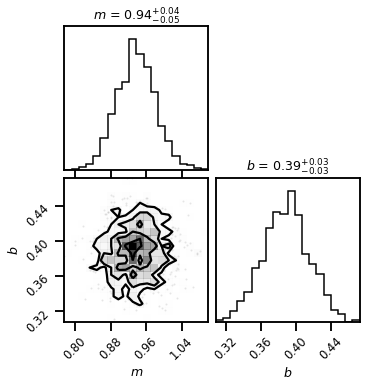

In [6]:
import corner

flat_samples = sampler.get_chain(discard=500, thin=10, flat=True)
    
corner.corner(flat_samples, labels=[r'$m$', r'$b$'], show_titles=True);

The above plot shows the posterior distribution of $m$ and $b$. The means of the distribution are pretty close to the MLEs.

### Plot the credible region of the predicted $\hat{y}$

In [7]:
x_test = np.linspace(-1.5, 1.5, 1000)
y_pred_list = []

for i in tqdm.tqdm_notebook(range(100)):
    m, b = flat_samples[i]
    y_pred = m*x_test + b
    y_pred_list.append(y_pred)

y_mean = np.mean(y_pred_list, axis=0)
y_sigma = np.std(y_pred_list, axis=0)

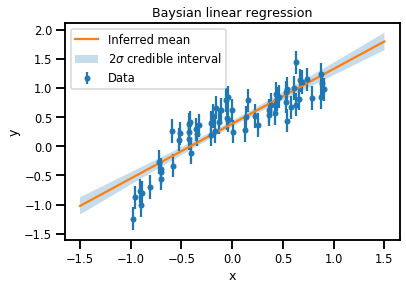

In [8]:
plt.errorbar(x, y, yerr=y_uncertainty, marker='o', ls='none', label='Data', markersize=5)
plt.plot(x_test, y_mean, '-', label='Inferred mean');

        
plt.fill_between(x_test,
                y1=y_mean + 2*y_sigma,
                y2=y_mean - 2*y_sigma,
                alpha=0.25, label=r'2$\sigma$ credible interval', zorder=-20)
plt.title(r'Baysian linear regression')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

The orange line corresponds to the means of the posteriors for $m$ and $b$. The blue shaded region is 2$\sigma$ interval for $p(\hat{y} \mid \hat{x}, M, D)$, which is the posterior predictive distribution of $\hat{y}$.

## Posterior predictive distribution

If we want to predict $\hat{y}$ for a given $\hat{x}$ with our model, then we are interested in the posterior predictive distribution $p(\hat{y} \mid \hat{x}, D)$. With our inference from only one model, the posterior predictive distribution will be model dependent $p(\hat{y} \mid \hat{x}, M, D)$, which is infact the blue shaded region in the above plot. To make this distribution model independent, we need to integrate/sum over all the models as

$$ p(\hat{y} \mid \hat{x}, D) = \sum_{M} p(\hat{y} \mid \hat{x}, M, D) p(M \mid D) = \sum_{M} p(\hat{y} \mid \hat{x}, D, M) \frac{p(D \mid M) p(M)}{p(D)} \propto \sum_{M} p(\hat{y} \mid \hat{x}, M, D) p(D \mid M) $$

The last term on the above equation contains the evidence term $p(D \mid M)$ and the proportionality relation holds if we equally weight all the models *a priori* and the prior $p(M)$ is uniform.

We will use `dynesty` to compute model evidences using nested sampling for a few models with increasing polyonomial order, and then combine the model posteriors weighted by their evidence ratios to approximate a model-free posterior predictive distribution.

In [9]:
import dynesty
from dynesty import plotting as dyplot

First, with a linear model: $\hat{y} = b + m\hat{x}$.

In [10]:
results = []
log_evidences = []

In [11]:
ndim = 2

def prior_transform_lin(u):
    """
    Transform unit cube samples `u` to a flat prior between in each variable.
    """    
    center = np.array([0,  0.])
    width = np.array([1, 10.])
    
    return width * (2. * u - 1.) + center


def log_likelihood_lin(params):
    b, m = params
    
    return -0.5 * np.sum((y - m*x -b)**2 / y_uncertainty**2) \
                - float(len(y)) * (0.5 * np.log(2*np.pi) + np.log(y_uncertainty))

sampler = dynesty.NestedSampler(log_likelihood_lin, prior_transform_lin, ndim, nlive=500)

sampler.run_nested(dlogz=0.01)
res = sampler.results

results.append(res)
log_evidences.append(res.get('logz')[-1])

print('num params: # {}'.format(ndim))
res.summary()

6625it [00:10, 611.65it/s, +500 | bound: 14 | nc: 1 | ncall: 27635 | eff(%): 25.783 | loglstar:   -inf < -13.569 <    inf | logz: -22.195 +/-  0.174 | dlogz:  0.000 >  0.010]

num params: # 2
Summary
nlive: 500
niter: 6625
ncall: 27635
eff(%): 25.783
logz: -22.195 +/-  0.174


We can plot the posterior distribution sampled using `dynesty`, which is identical to the one sampled with `emcee`.

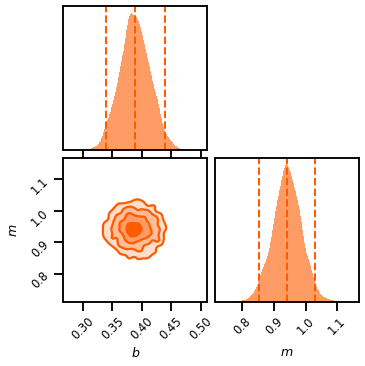

In [12]:
n_params = 2
fg, ax = dyplot.cornerplot(res, color=sns.xkcd_rgb['bright orange'],
                           labels=[r'$b$', r'$m$'],
                          )

plt.show()

Now, let's increase the polynomial order of our model to some $n$: $\hat{y}_{n} = p_0 + p_1\hat{x} + \dots + p_{n} \hat{x}^{n}$, and compute evidences for all these models. Here, we take $n$ up to 7.

In [13]:
import copy

for n in range(2, 7):
    ndim = n + 1 # number of free parameters
    
    # uniform prior for dynesty
    def prior_transform_polynomial(u):
        """
        Transform unit cube samples `u` to a flat prior between in each variable.
        """
        center = np.array([0, 0, 0, 0, 0, 0, 0., 0., 0.])[:ndim]
        width = np.array([1., 10., 10., 10, 10., 10, 10, 10])[:ndim]

        return width * (2. * u - 1.) + center


    def log_likelihood_polynomial(params):
        model = 0
        for i, p in enumerate(params):
            model += p * x**i

        return -0.5 * np.sum((y - model)**2 / y_uncertainty**2) \
                    - float(len(y)) * (0.5 * np.log(2*np.pi) + np.log(y_uncertainty))


    sampler = dynesty.NestedSampler(log_likelihood_polynomial, prior_transform_polynomial, ndim, nlive=500)

    sampler.run_nested(dlogz=0.01)
    
    results.append(copy.deepcopy(sampler.results))
    log_evidences.append(results[-1].get('logz')[-1])
    
    print('polynomial order: {}'.format(n))
    print('num params: # {}'.format(ndim))
    results[-1].summary()

8835it [00:15, 561.52it/s, +500 | bound: 21 | nc: 1 | ncall: 32905 | eff(%): 28.370 | loglstar:   -inf <  7.574 <    inf | logz: -5.467 +/-  0.215 | dlogz:  0.000 >  0.010]  
115it [00:00, 1147.92it/s, bound: 0 | nc: 1 | ncall: 632 | eff(%): 18.196 | loglstar:   -inf < -24153.232 <    inf | logz: -24160.369 +/-  0.169 | dlogz: 24123.268 >  0.010]

polynomial order: 2
num params: # 3
Summary
nlive: 500
niter: 8835
ncall: 32905
eff(%): 28.370
logz: -5.467 +/-  0.215


10700it [00:20, 514.40it/s, +500 | bound: 28 | nc: 1 | ncall: 38198 | eff(%): 29.321 | loglstar:   -inf < 15.582 <    inf | logz: -1.187 +/-  0.244 | dlogz:  0.000 >  0.010]
0it [00:00, ?it/s]

polynomial order: 3
num params: # 4
Summary
nlive: 500
niter: 10700
ncall: 38198
eff(%): 29.321
logz: -1.187 +/-  0.244


12238it [00:26, 469.84it/s, +500 | bound: 34 | nc: 1 | ncall: 43164 | eff(%): 29.511 | loglstar:   -inf < 16.025 <    inf | logz: -3.816 +/-  0.264 | dlogz:  0.000 >  0.010]
0it [00:00, ?it/s]

polynomial order: 4
num params: # 5
Summary
nlive: 500
niter: 12238
ncall: 43164
eff(%): 29.511
logz: -3.816 +/-  0.264


13483it [00:32, 418.08it/s, +500 | bound: 41 | nc: 1 | ncall: 48064 | eff(%): 29.092 | loglstar:   -inf < 18.394 <    inf | logz: -3.937 +/-  0.278 | dlogz:  0.000 >  0.010] 
0it [00:00, ?it/s]

polynomial order: 5
num params: # 6
Summary
nlive: 500
niter: 13483
ncall: 48064
eff(%): 29.092
logz: -3.937 +/-  0.278


13952it [00:38, 361.92it/s, +500 | bound: 47 | nc: 1 | ncall: 53092 | eff(%): 27.221 | loglstar:   -inf < 18.531 <    inf | logz: -4.737 +/-  0.282 | dlogz:  0.000 >  0.010] 


polynomial order: 6
num params: # 7
Summary
nlive: 500
niter: 13952
ncall: 53092
eff(%): 27.221
logz: -4.737 +/-  0.282


In [14]:
for i, logZ in enumerate(log_evidences):
    print('log(evidence) for model with polynomial order {}: {:.2f}'.format(i+1, logZ))

log(evidence) for model with polynomial order 1: -22.20
log(evidence) for model with polynomial order 2: -5.47
log(evidence) for model with polynomial order 3: -1.19
log(evidence) for model with polynomial order 4: -3.82
log(evidence) for model with polynomial order 5: -3.94
log(evidence) for model with polynomial order 6: -4.74


The $\log \mathcal{Z}$ -- with $\mathcal{Z}$ being the model evidence -- has peaked for a cubic model. Then, the model evidence has indeed served its purpose of highlighting better models that are balanced between underfitting (less than necessary model parameters) and overfitting (more than necessary model parameters).

Now, let's combine thes posteriors of these models after weighting them by relative evidence ratio $\mathcal{Z}/\mathcal{Z}_{\rm max}$. This will effectively perform a Bayesian Model Averaging (BMA) over our adopted models, in other words the resultant posterior will be marginalized over our model choices.

In [15]:
equal_weight_samples = []

# samples from nested samplings comes with weights, so we resample them to have the samples equally weighted.
for res in results:
    samples = res.samples
    weights = res.logwt
    
    equal_weight_samples.append(dynesty.utils.resample_equal(samples, np.exp(weights)/np.sum(np.exp(weights))))

In [16]:
n_max_evidece = 1000 # number of samples from the highest-evidence model

# number of samples from other posteriors will depend on evidence ratio

x_test = np.linspace(-1.5, 1.5, 1000)
y_pred_list = []

max_log_evidence = np.max(log_evidences)


for k in tqdm.tqdm_notebook(range(len(log_evidences))):
    log_evidence = log_evidences[k]
    
    print('Number of samples from model with order {}: {}'.format(
                        k+1,
                        int(n_max_evidece * np.exp(log_evidence - max_log_evidence))))

# combine samples from the model posteriors weighted by the relative evidence ratios    
for k in tqdm.tqdm_notebook(range(len(log_evidences)), desc='model'):
    log_evidence = log_evidences[k]
    
    random_indices = np.random.randint(
                        low=0, high=len(equal_weight_samples[k]),
                        size=int(n_max_evidece * np.exp(log_evidence - max_log_evidence)))
    
    for i in tqdm.tqdm_notebook(random_indices, desc='samples'):
        y_pred = np.zeros_like(x_test)
        
        ndim = len(equal_weight_samples[k][i])
        for j in range(ndim):
            y_pred += equal_weight_samples[k][i][j] * x_test**j
            
        y_pred_list.append(y_pred)


y_mean = np.mean(y_pred_list, axis=0)
y_sigma = np.std(y_pred_list, axis=0)

Number of samples from model with order 1: 0
Number of samples from model with order 2: 13
Number of samples from model with order 3: 1000
Number of samples from model with order 4: 72
Number of samples from model with order 5: 63
Number of samples from model with order 6: 28



In [17]:
len(y_pred_list), len(y_pred_list[0]), y_mean.shape

(1176, 1000, (1000,))

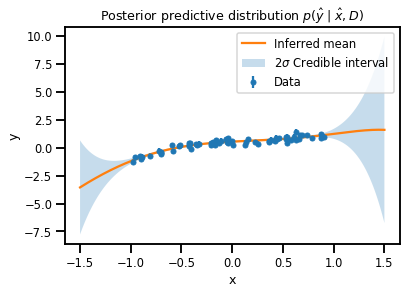

In [18]:
plt.errorbar(x, y, yerr=y_uncertainty, marker='o', ls='none', label='Data', markersize=5)
plt.plot(x_test, y_mean, '-', label='Inferred mean');

        
plt.fill_between(x=x_test,
                y1=(y_mean + 2*y_sigma).ravel(),
                y2=(y_mean - 2*y_sigma).ravel(),
                alpha=0.25, label=r'$2\sigma$ Credible interval', zorder=-20)
plt.title(r'Posterior predictive distribution $p(\hat{y} \mid \hat{x}, D)$')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

This is what we should expect from a posterior predictive distribution: the credible region is narrow where we have data (along $x$), but widens up quite a bit outside the region where the data lies.

# Regression with Tensorflow probability

First we will do a linear regreesion with `tensorflow` to obtain MLE of $\hat{y}$ for the same data generated above.

In [19]:
import tensorflow as tf
import tensorflow_probability as tfp

tfd = tfp.distributions

In [20]:
tf.__version__, tfp.__version__

('2.0.0', '0.8.0')

In [21]:
def reshape(x):
    """
    Reshape 1D array into 2D array to make it look like TensorFlow training data.
    """
    return np.array([[value] for value in x])

In [22]:
x = reshape(x)

# build model
model = tf.keras.Sequential([
  tf.keras.layers.Dense(1),
])

# compile and fit
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.05), loss='mse')
model.fit(x, y, epochs=500, verbose=False)

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                multiple                  2         
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


This model is fitting 2 parameters $w$ and $b$: $\hat{y} = w\hat{x} + b$.

In [24]:
# print values of w and b
[print(np.squeeze(w.numpy())) for w in model.weights];

0.9496513
0.38934273


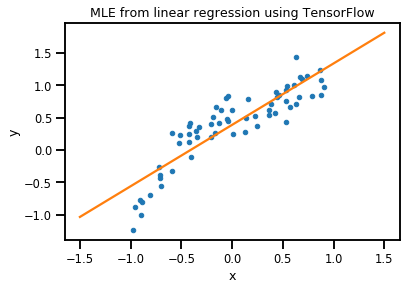

In [25]:
x_test = reshape(np.linspace(-1.5, 1.5, 100).astype(np.float32))
yhat = model(x_test)

w = np.squeeze(model.layers[0].kernel.numpy())
b = np.squeeze(model.layers[0].bias.numpy())

plt.plot(x.squeeze(), y, '.', label='observed')
plt.plot(x_test, yhat, label='mean')

plt.xlabel('x')
plt.ylabel('y')
plt.title('MLE from linear regression using TensorFlow');

## Linear Regression with uncertainty from Bayesian Neural Network

In the framework of machine learning, we want to obtain  the posterior predictive distribution $p(\hat{y} \mid \hat{x}, D) = \int \mathrm{d}\mathbf{w} p(\hat{y} \mid \hat{x}, \mathbf{w}, D) p(\mathbf{w} \mid D)$, where the weights $\mathbf{w}$ -- which includes the bias terms -- are the model parameters. 

For a moderately sized neural network, the number of parameters in $\mathbf{w}$ makes the optimization to obtain $p(\mathbf{w} \mid D)$ computationally intractable. So, we would like to approximate $q(\mathbf{w} \mid \mathbf{\theta}) \approx p(\mathbf{w} \mid D)$, where $\theta$ is a distribution function (or, model) that is easy to use, e.g., a Gaussian. We want to first train the network to find $q(\mathbf{w} \mid \mathbf{\theta})$. Then, the posterior predictive distribution $p(\hat{y} \mid \hat{x}, D)$ can be obtained by integrating over $\mathbf{w}$ through sampling from the $q(\mathbf{w} \mid \mathbf{\theta})$. 

Mathematically, the optimization during the training is done to minimize this cost function:

$$
\mathcal{F}(\mathcal{D},\boldsymbol{\theta}) = 
\mathrm{KL}(q(\mathbf{w} \lvert \boldsymbol{\theta}) \mid\mid p(\mathbf{w})) -
\mathbb{E}_{q(\mathbf{w} \lvert \boldsymbol{\theta})} \log p(\mathcal{D} \lvert \mathbf{w}).
$$

This cost function is called the **variational free energy**. The Kullback-Leibler divergence term on the right-hand side is called the *complexity cost* and the last term that includes the likelihood $p(D \mid \mathbf{w})$ is called the *likelihood cost*.

See these references for more mathematics behind the variational free energy:

1. Appendix of [this link](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_neural_networks.ipynb).
2. [This link](https://ermongroup.github.io/cs228-notes/inference/variational/) for a slightly more detailed discussion on the interpreation.
3. Appendix B of [this link](https://blog.tensorflow.org/2019/03/regression-with-probabilistic-layers-in.html) for how `DenseVariational` layer from `tensorflow_probability` works to minimize this cost function.


In [26]:
# Specify the surrogate posterior over `keras.layers.Dense` `kernel` and `bias`.
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])

# Specify the prior over `keras.layers.Dense` `kernel` and `bias`.
def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype, trainable=True), # set trainable to False to not optimize the prior
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
])

In [27]:
# build model
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
])

# likelihood function
def neg_log_likelihood(y_true, y_pred, sigma=y_uncertainty):
    dist = tfd.Normal(loc=y_pred, scale=sigma)
    return tf.keras.backend.sum(-dist.log_prob(y_true))


# fit the model
model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.01), loss=neg_log_likelihood)
model.fit(x, y, epochs=1000, verbose=False);

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational (DenseVari (None, 1)                 6         
Total params: 6
Trainable params: 6
Non-trainable params: 0
_________________________________________________________________


This model is fitting 6 parameters: posterior mean, posterior standard deviation, prior mean for each of $w$ and $b$ in $y = w x + b$.

In [29]:
[print(np.squeeze(w.numpy())) for w in model.weights];

[ 0.94678974  0.37386012 -2.8341584  -3.0044334 ]
[0.94416344 0.40572202]


In [30]:
y_pred_list = []

for i in tqdm.tqdm_notebook(range(100)):
    y_pred = model.predict(x_test)
    y_pred_list.append(y_pred)

y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

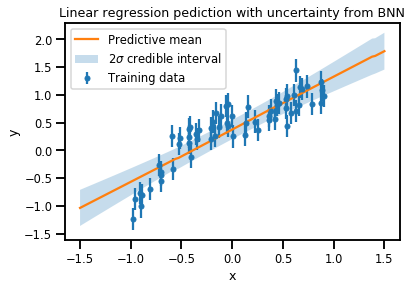

In [31]:
plt.errorbar(x, y, yerr=y_uncertainty, marker='o', ls='none', label='Training data', markersize=5)
plt.plot(x_test, y_mean, '-', label='Predictive mean');

# for _pred in y_pred_list[:10]:
#     plt.plot(x_test, _pred, c='grey', alpha=0.8, linewidth=0.5)

plt.fill_between(x_test.ravel(),
                y_mean + 2*y_sigma,
                y_mean - 2*y_sigma,
                alpha=0.25, label=r'$2\sigma$ credible interval', zorder=-20)
plt.title('Linear regression pediction with uncertainty from BNN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();

## BNN for general regression

Now, we want to go beyond linear regression with BNN by increasing the number of neurons.

In [32]:
# Build model.
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(1,)),
    tfp.layers.DenseVariational(4, posterior_mean_field, prior_trainable, activation='elu'),
    tfp.layers.DenseVariational(1, posterior_mean_field, prior_trainable),
])

In [33]:
model.compile(loss=neg_log_likelihood, optimizer=tf.optimizers.Adam(lr=0.03), metrics=['mse'])
model.fit(x, y, epochs=1500, verbose=0);

In [34]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_variational_1 (DenseVa (None, 4)                 24        
_________________________________________________________________
dense_variational_2 (DenseVa (None, 1)                 15        
Total params: 39
Trainable params: 39
Non-trainable params: 0
_________________________________________________________________


In [35]:
x_test = np.linspace(-1.5, 1.5, 1000).reshape(-1, 1)
y_pred_list = []

for i in tqdm.tqdm_notebook(range(100)):
    y_pred = model.predict(x_test)
    y_pred_list.append(y_pred)

y_preds = np.concatenate(y_pred_list, axis=1)
y_mean = np.mean(y_preds, axis=1)
y_sigma = np.std(y_preds, axis=1)

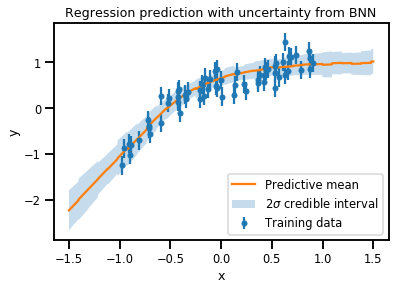

In [36]:
plt.errorbar(x, y, yerr=y_uncertainty, marker='o', ls='none', label='Training data', markersize=5)
plt.plot(x_test, y_mean, '-', label='Predictive mean');
        
plt.fill_between(x_test.ravel(),
                y_mean + 2*y_sigma,
                y_mean - 2*y_sigma,
                alpha=0.25, label=r'$2\sigma$ credible interval', zorder=-20)
plt.title('Regression prediction with uncertainty from BNN')
plt.xlabel('x')
plt.ylabel('y')
plt.legend();